                                                                                              
<center> <h style="font-size:200%" ><b>Google Cloud & NCAA® ML Competition</b></h1> </center>
<center> <h style="font-size:150%" > <b>Predicting March Madness<br>
    David Walborn & Michael Feeser<br>
    March-April, 2019</b></h1> </center>
<img align="center" width="300" height="200" src="https://storage.googleapis.com/kaggle-media/competitions/march-madness-2018/lockup_cloud.png">

**About this notebook**
* **Goal:** Predict the outcomes of the 2019 NCAA Men's basketball tournament
* **Data:** Historical NCAA Men's regular season and tournment data from 2003-2019
* **Methodology:** The model applies a logistic regression technique to predict winners
* **Competition:** For more information about the competition, please visit the [Kaggle Competition Page](https://www.kaggle.com/c/mens-machine-learning-competition-2019/overview)

**Import Packages**

In [1]:
# Import Python Packages
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("display.max_rows", None)
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Regular Season Data
* Our ML model will be trained on historical regular season data. That will allow us to use 2019 regular season data when released to predict 2019 tournament outcomes.

## Load Data

* **Kaggle Data:** Provided by Kaggle competition hosts. For a complete list of data & data dictionary please refer to the [Kaggle Data Information Page](https://www.kaggle.com/c/mens-machine-learning-competition-2019/data)

In [2]:
# Team Info
dim_teams = pd.read_csv("CSV_Files/DataFiles/Teams.csv")

pd.read_csv("CSV_Files/MasseyOrdinals_thru_2019_day_128.csv")

# Compact Results
rc_regularseason = pd.read_csv("CSV_Files/DataFiles/RegularSeasonCompactResults.csv")

# Rankings
dim_rankings = pd.read_csv("CSV_Files/MasseyOrdinals/MasseyOrdinals.csv")

# 2019 Rankings
dim_rankings_19 = pd.read_csv("CSV_Files/MasseyOrdinals_thru_2019_day_128.csv")

# Merge 2019 data on regular season data
dim_rankings = dim_rankings.append(dim_rankings_19).drop_duplicates().reset_index(drop=True)

## Create Team Rank Features

* **KenPom Rankings:** Ken Pomeroy’s rankings of college basketball teams is based on factors like offensive and defensive efficiency, tempo and strength of schedule. For more information about the rankings, refer to [Ken Pomeroy's Website](https://kenpom.com/)
 <br> <br>
* **Rank Features:** Using rank we create features create more context regarding a team's games during the season. Not only are we interested in the raw number of wins and losses, we would like to create features to define how impressive a win was, or how forgiveable a loss may be 

In [3]:
#get 2018 Ken Pom rankings for all weeks
seasons = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,2019]
rank_average_final = pd.DataFrame()
for i in seasons:
    rank_yeari = dim_rankings.loc[( dim_rankings['Season']==i )&(dim_rankings['SystemName']=='POM')]

    #get a table with average, min, and max Ken Pom rankings across the season
    rank_average = pd.pivot_table(rank_yeari, values = ['OrdinalRank']
                           , index = ['TeamID']
                           , columns = ['SystemName']
                           , aggfunc=('mean','max','min')
                           , fill_value=0)

    #drop column levels and rename columns
    rank_average.columns = rank_average.columns.droplevel([0,2])
    rank_average.columns = ['Rank_max','Rank_mean','Rank_min']

    #take the top 25 teams in terms of average rank as a list
    top_25_list = rank_average.nsmallest(25,'Rank_mean').index.tolist()
    rank_average = rank_average.reset_index()
    
    #Bring Year back in
    rank_average['Season'] = i
    rank_average_final = rank_average_final.append(rank_average)

rank_average_final['Rank_Range'] = rank_average_final['Rank_max']-rank_average_final['Rank_min'] 

* **Wins against top X teams:** To define a win against a top 25 team, we each team's average rank over the season for simplicity. This also helps us consider a team's rank as an entire season's body of work to avoid bias from a team being 'overrated' or 'underrated' at any point in the season

In [4]:
#2018 Reg Season Results
results_ranked_final = pd.DataFrame()
for i in seasons:
    rc_regularseason_i = rc_regularseason.loc[rc_regularseason['Season']==i].drop(['Season'],axis=1)
    rank_average_final_i = rank_average_final.loc[rank_average_final['Season']==i].drop(['Season'],axis=1)
    
    #Merge Winning Team Rankings
    results_ranked = pd.merge(rc_regularseason_i, rank_average_final_i, how = 'left', left_on=['WTeamID'], right_on=['TeamID'])
    results_ranked = results_ranked.drop(['TeamID', 'NumOT'], axis=1)
    results_ranked = results_ranked.rename(index=str, columns = {'Rank_max': 'W_Rank_max', 'Rank_mean': 'W_Rank_mean', 'Rank_min': 'W_Rank_min','Rank_Range':'W_Rank_Range'})

    #Merge Losing Team Rankings
    results_ranked = pd.merge(results_ranked, rank_average_final_i, how = 'left', left_on=['LTeamID'], right_on=['TeamID'])
    results_ranked = results_ranked.drop(['TeamID'], axis=1)
    results_ranked = results_ranked.rename(index=str, columns = {'Rank_max': 'L_Rank_max', 'Rank_mean': 'L_Rank_mean', 'Rank_min': 'L_Rank_min','Rank_Range':'L_Rank_Range'})

    #Margin of Victory
    results_ranked['MOV'] = results_ranked['WScore'] - results_ranked['LScore']

    #Wins against top 10, 25, 50, 100
    results_ranked['W_Top_100'] = (results_ranked['W_Rank_mean'] <= 100)&(results_ranked['W_Rank_mean'] > 25)
    results_ranked['L_Top_100'] = (results_ranked['L_Rank_mean'] <= 100)&(results_ranked['L_Rank_mean'] > 25)
    results_ranked['W_Top_25'] = (results_ranked['W_Rank_mean'] <= 25)&(results_ranked['W_Rank_mean'] > 10)
    results_ranked['L_Top_25'] = (results_ranked['L_Rank_mean'] <= 25)&(results_ranked['L_Rank_mean'] > 10)
    results_ranked['W_Top_10'] = results_ranked['W_Rank_mean'] <= 10
    results_ranked['L_Top_10'] = results_ranked['L_Rank_mean'] <= 10
    results_ranked['Season'] = i
    
    results_ranked_final = results_ranked_final.append(results_ranked)

results_ranked = results_ranked_final
del results_ranked_final

* **Delta Rank:** Feature to determine how a team's rank has trended over the season. Has their performance improved or declined? The idea is to identify teams trending up and trending down as we head into the tournament.

In [5]:
# Create Delta Rank Feature: How has the team's rank trended from the first rank of the season to their rank entering the NCAA tournament
df_delta_final = pd.DataFrame()

for i in seasons:
    dim_rankings_i = dim_rankings.loc[dim_rankings['Season']==i]
    
    # Ken Pom Rankings
    rank_i = dim_rankings_i.loc[dim_rankings_i['SystemName']=='POM']

    # Find First Rankings
    df_firstrank = rank_i.loc[rank_i['RankingDayNum'] == rank_i['RankingDayNum'].min()]
    df_firstrank = df_firstrank.rename(columns={'OrdinalRank' : 'First_Rank'})
    df_firstrank = df_firstrank.drop(['RankingDayNum', 'SystemName'], axis=1)

    # Find Last Rankings
    df_lastrank = rank_i.loc[rank_i['RankingDayNum'] == rank_i['RankingDayNum'].max()]
    df_lastrank = df_lastrank.rename(columns={'OrdinalRank' : 'Last_Rank'})
    df_lastrank = df_lastrank.drop(['RankingDayNum', 'SystemName'], axis =1)

    # Find Delta
    df_delta = pd.merge(df_firstrank, df_lastrank, on=['Season', 'TeamID'])
    df_delta['Rank_Delta'] = df_delta['First_Rank'] - df_delta['Last_Rank']

    # Remove Unnesscary cols
    df_delta = df_delta.drop(['Season','First_Rank', 'Last_Rank'], axis =1)
    
    # Iterate on Final Df
    df_delta['Season'] = i
    df_delta_final = df_delta_final.append(df_delta)
    
df_delta_final.drop_duplicates(inplace=True)

# Preview Output
df_delta_final.head()

,TeamID,Rank_Delta,Season
0,1102,-56,2003
1,1103,28,2003
2,1104,-18,2003
3,1105,12,2003
4,1106,-93,2003


* **Last 28 days:** The tournament is all about teams who get hot at the right time. In addition to the delta rank feature of a team's trend over the season, we would like to add a feature for a team's performance in the last 28 days before the tournament (Approx 5-10 games for each team).

In [6]:
# Create a list of teams
teams = dim_teams['TeamID'].unique()

# Create features for quality of wins i.e. what was the average rank of the opposing team
wins_reg = [] #wins against teams outside top 25
wins_top100 = [] #wins against top 25 (excluding top 25)
wins_top25 = [] #wins against top 25 (excluding top 10)
wins_top10 = [] #wins against top 10

# Create features for quality of losses i.e. what was the average rank of the opposing team
losses_reg = [] # losses against teams outside top 25
losses_top100 = [] # losses against top 25 (excluding top 25)
losses_top25 = [] # losses against top 25 (excluding top 10)
losses_top10 = [] # losses against top 10

ppg = [] # Points per game
papg = [] # Points allowed per game
avgMOV = [] # Average Margin of victory
team_ID_list = []
season_list = []
worst_5_loss_margin = []
last_28days_wins = []
last_28days_losses = []

#  Avoid Error divide by 0, NaN error: invalid value encountered in longlong_scalars
np.seterr(divide='ignore', invalid='ignore')

# Iterate across teams and calculate stats for each stored in list
for i in seasons:
    for team in dim_teams.loc[(dim_teams['FirstD1Season'] <= i) & (dim_teams['LastD1Season'] >= i)]['TeamID'].unique():
        team_ID_list.append(team)
        season_list.append(i)
        
        ws_reg = len(results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['L_Top_25']==0)& (results_ranked['Season']==i)])
        ws_top100 = len(results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['L_Top_100']==1)&(results_ranked['Season']==i)])
        ws_top25 = len(results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['L_Top_25']==1)&(results_ranked['Season']==i)])
        ws_top10 = len(results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['L_Top_10']==1)&(results_ranked['Season']==i)])

        wins_reg.append(ws_reg)
        wins_top100.append(ws_top100)
        wins_top25.append(ws_top25)
        wins_top10.append(ws_top10)
        
        ls_reg = len(results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['W_Top_25']==0)&(results_ranked['Season']==i)])
        ls_top100 = len(results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['W_Top_100']==1)&(results_ranked['Season']==i)])
        ls_top25 = len(results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['W_Top_25']==1)&(results_ranked['Season']==i)])
        ls_top10 = len(results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['W_Top_10']==1)&(results_ranked['Season']==i)])
        
        losses_reg.append(ls_reg)
        losses_top100.append(ls_top100)
        losses_top25.append(ls_top25)
        losses_top10.append(ls_top10)
        
        games_played = ws_reg + ws_top100 + ws_top25 + ws_top10 + ls_reg + ls_top100 + ls_top25 + ls_top10
            
        # Calculate number of games played and divide points in both wins and losses by games played to get PPG 
        points_in_win = results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['Season']==i)]['WScore'].sum()
        points_in_loss = results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['Season']==i)]['LScore'].sum()
        Total_pts = points_in_win + points_in_loss
        ppg.append(Total_pts/games_played)
    
        # Get points against using the same method reversed
        points_against_in_win = results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['Season']==i)]['LScore'].sum()
        points_against_in_loss = results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['Season']==i)]['WScore'].sum()
        Total_pts_against = points_against_in_win + points_against_in_loss
        papg.append(Total_pts_against/games_played)
    
        MOV_in_wins = results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['Season']==i)]['MOV'].sum()
        MOL_in_losses = results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['Season']==i)]['MOV'].sum()
        Worst5_Loss_margin = results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['Season']==i)].nlargest(5,'MOV')['MOV'].mean()
        avgMOV.append((MOV_in_wins - MOL_in_losses) / (games_played))
        worst_5_loss_margin.append(Worst5_Loss_margin)
        
        # Adding wins in last 28 days of play and losses in the same time frame (approximately last 5-10 games)
        l_10_w = len(results_ranked.loc[(results_ranked['WTeamID']==team)&(results_ranked['Season']==i)&(results_ranked['DayNum']>100)])
        l_10_l = len(results_ranked.loc[(results_ranked['LTeamID']==team)&(results_ranked['Season']==i)&(results_ranked['DayNum']>100)])
        last_28days_wins.append(l_10_w)
        last_28days_losses.append(l_10_l)

# Create a dictionary with the column names for the final df and create the dataframe with reg season team data
team_stats_dict = {'TeamID':team_ID_list, 'Season': season_list}
wl_dict = {'last_28days_wins':last_28days_wins,'last_28days_losses':last_28days_losses,'Wins_NonT100':wins_reg,'Wins_T10':wins_top10,'Wins_T25':wins_top25,'Wins_T100':wins_top100,'Losses_NonT100':losses_reg,'Losses_T100':losses_top100,'Losses_T25':losses_top25,'Losses_T10':losses_top10}
team_stats_dict.update(wl_dict)
core_stats_dict = {'PPG':ppg,'PAPG':papg,'avgMOV':avgMOV,'Worst_5_loss_margin':worst_5_loss_margin}
team_stats_dict.update(core_stats_dict)
Final_df = pd.DataFrame.from_dict(team_stats_dict)

# Merge Delta rank over Season feature
Final_df = pd.merge(Final_df, df_delta_final, on=['TeamID','Season'])

# Merge on ranking for the team
Final_df = pd.merge(Final_df,rank_average_final,on=['TeamID','Season'])

## Training Data Set

In [7]:
Final_df.head()

,TeamID,Season,last_28days_wins,last_28days_losses,Wins_NonT100,Wins_T10,Wins_T25,Wins_T100,Losses_NonT100,Losses_T100,...,Losses_T10,PPG,PAPG,avgMOV,Worst_5_loss_margin,Rank_Delta,Rank_max,Rank_mean,Rank_min,Rank_Range
0,1102,2003,2,6,12,0,0,2,16,10,...,1,39.097561,38.926829,0.170732,19.2,-56,167,140.266667,84,83
1,1103,2003,4,3,13,0,0,2,14,3,...,0,66.468750,65.937500,0.531250,13.8,28,202,179.333333,158,44
2,1104,2003,4,4,14,0,3,8,8,6,...,1,45.116279,42.325581,2.790698,15.8,-18,43,26.533333,14,29
3,1105,2003,2,6,7,0,0,0,18,2,...,0,66.642857,71.178571,-4.535714,27.4,12,319,311.666667,305,14
4,1106,2003,3,5,13,0,0,0,15,2,...,0,59.366667,59.500000,-0.133333,18.6,-93,263,237.533333,170,93


# NCAA Tournament Data

## Load Data

In [8]:
# Creating dataframe of tournament games
tourney_seeds = pd.read_csv("CSV_Files/Stage2DataFiles/NCAATourneySeeds.csv")
tourney_seeds['Seed'] = pd.to_numeric(tourney_seeds['Seed'].apply(lambda x: x[1:3]))
tourney_seeds = tourney_seeds.loc[(tourney_seeds['Season']>2002)&(tourney_seeds['Season']<2020)]

possible_t_matchups = pd.merge(tourney_seeds,tourney_seeds,how='left',on=('Season'),suffixes=['_main','_opponent'])
possible_t_matchups = possible_t_matchups.loc[possible_t_matchups['TeamID_main'] < possible_t_matchups['TeamID_opponent']]

# Preview Tournament Data
tourney_seeds.head()

,Season,Seed,TeamID
1154,2003,1,1328
1155,2003,2,1448
1156,2003,3,1393
1157,2003,4,1257
1158,2003,5,1280


* **Seed Win Rate:** We will add in one last feature from historical tournment data. How often do each of these seeds perform against one another. For example, a 16 seed has only beat a 1 seed once in history (i.e. 2018 NCAA Tournament Virginia lost to UMBC)

In [9]:
tourney_results = pd.read_csv("CSV_Files/DataFiles/NCAATourneyCompactResults.csv")
tourney_results = tourney_results.loc[(tourney_results['Season']>2002)&(tourney_results['Season']<2020)]
results = []
Team_to_p = []
Opp = []

# Add 1 and 0 depending on if the lower seed won and create columns to join lower seed with games to predict
for index, row in tourney_results.iterrows():
    if row[2] < row[4]:
        results.append(1)
        Team_to_p.append(row[2])
        Opp.append(row[4])
    else:
        results.append(0)
        Team_to_p.append(row[4])
        Opp.append(row[2])
        
tourney_results['Outcome'] = results
tourney_results['TeamID_main'] = Team_to_p
tourney_results['TeamID_opponent'] = Opp
tourney_outcomes = tourney_results[['Season','Outcome','TeamID_main','TeamID_opponent']]
possible_t_matchups = pd.merge(possible_t_matchups, tourney_outcomes, how = 'left', on=['TeamID_main','TeamID_opponent','Season'])

In [10]:
# Create a reference table for each seed's chance aginst every other seed number based on historical win rates
seed_winrate = pd.merge(tourney_outcomes,tourney_seeds,how='left',left_on=['Season','TeamID_main'],right_on=['Season','TeamID'])
seed_winrate.rename(index=str, columns={"Seed": "TeamSeed_main"},inplace=True)
seed_winrate = pd.merge(seed_winrate,tourney_seeds,how='left',left_on=['Season','TeamID_opponent'],right_on=['Season','TeamID'])
seed_winrate.rename(index=str, columns={"Seed": "TeamSeed_opponent"},inplace=True)

# Dropping irrelevant columns
seed_winrate.drop(['TeamID_main','TeamID_opponent','Season','TeamID_x','TeamID_y'],axis=1,inplace=True)
prim_seed = []
opp_seed = []
win_rate = []

# loop through each possible seed matchup and compute the probability of a seed beating that seed
for seed in range(1,17):
    for oth_seed in range(1,17):
        prim_seed.append(seed)
        opp_seed.append(oth_seed)
        if seed == oth_seed:
            win_rate.append(.5)
        else:
            #add up wins when the seed was the main and when they were the opponent and won; take the proportion won
            wm = len(seed_winrate.loc[(seed_winrate['TeamSeed_main']==seed)&(seed_winrate['TeamSeed_opponent']==oth_seed)&(seed_winrate['Outcome']==1)])
            wo = len(seed_winrate.loc[(seed_winrate['TeamSeed_opponent']==seed)&(seed_winrate['TeamSeed_main']==oth_seed)&(seed_winrate['Outcome']==0)])
            lm = len(seed_winrate.loc[(seed_winrate['TeamSeed_main']==seed)&(seed_winrate['TeamSeed_opponent']==oth_seed)&(seed_winrate['Outcome']==0)])
            lo = len(seed_winrate.loc[(seed_winrate['TeamSeed_opponent']==seed)&(seed_winrate['TeamSeed_main']==oth_seed)&(seed_winrate['Outcome']==1)])
            if (wo + wm + lm + lo) == 0:
                win_rate.append(.5)
            else:
                wr = (wm + wo) / (wo + wm + lm + lo)
                win_rate.append(wr)
            
ref_dict = {'Seed':prim_seed,'Opposing_Seed':opp_seed,'Chance':win_rate}

# This dataframe has each seed's odds against every other seed
Seed_chance_lookup = pd.DataFrame.from_dict(ref_dict)

# Preview odds of each seed performing against opponent seeds
Seed_chance_lookup.head()

,Seed,Opposing_Seed,Chance
0,1,1,0.500000
1,1,2,0.464286
2,1,3,0.666667
3,1,4,0.740741
4,1,5,0.863636


## Feature Training

In [11]:
# Merge the gms to predict with data for the given season
# Relabel team id to avoid column duplication (only for naming consistency)
training_data = possible_t_matchups
training_data['TeamID'] = training_data['TeamID_main']
training_data = training_data.drop(['TeamID_main'],axis=1)

# Merge data for the main team into the training data
training_data = pd.merge(training_data,Final_df,how='inner',on=['Season','TeamID'])

# Relabel opposing team id to avoid column duplication (only for naming consistency)
training_data['TeamID_opp'] = training_data['TeamID_opponent']
training_data = training_data.drop(['TeamID_opponent'],axis=1)

# Merge data for the opposing team
training_data = pd.merge(training_data,Final_df,how='inner',left_on=['Season','TeamID_opp'],right_on=['Season','TeamID'],suffixes=('_main', '_opponent'))

# Relabel outcome and drop duplicate columns
training_data = pd.merge(training_data,Seed_chance_lookup,how='left',left_on=['Seed_main','Seed_opponent'],right_on=['Seed','Opposing_Seed'])
training_data = training_data.drop(['Seed_main','Seed_opponent','TeamID_opp','Seed','Opposing_Seed'],axis=1)

* **Advantage Features:** In order to compare the features considering for the possible tournament matchups, we must compare how team's statistics match up against one another. For example, we would be interested in how many more PPG Team A averages than team B.

In [12]:
# Creating function for percent difference
def perc_diff(primaryteam,opponent):
    """takes the percent difference for any stat between one team and their opponent"""
    diff = 100*(primaryteam-opponent)
    avg = (primaryteam + opponent)/2
    return diff / avg
    
def raw_diff(primaryteam,opponent):
    """takes the raw difference of two numbers (placeholder)"""
    return primaryteam - opponent

#Create compound variables factoring the differences between the teams
#PPG
training_data['PPG_Adv'] = perc_diff(training_data['PPG_main'],training_data['PPG_opponent'])
training_data = training_data.drop(['PPG_main','PPG_opponent'],axis=1)

#PAPG
training_data['PAPG_Adv'] = perc_diff(training_data['PAPG_main'],training_data['PAPG_opponent'])
training_data = training_data.drop(['PAPG_main','PAPG_opponent'],axis=1)

#MOV
training_data['MOV_Adv'] = perc_diff(training_data['avgMOV_main'],training_data['avgMOV_opponent'])
training_data = training_data.drop(['avgMOV_main','avgMOV_opponent'],axis=1)

#rkdf advantage
training_data['Rank_Delta_Adv'] = raw_diff(training_data['Rank_Delta_main'],training_data['Rank_Delta_opponent'])
training_data = training_data.drop(['Rank_Delta_main','Rank_Delta_opponent'],axis=1)

#worst 5 loss MOV advantage
training_data['Worst_loss_Adv'] = perc_diff(training_data['Worst_5_loss_margin_main'],training_data['Worst_5_loss_margin_opponent'])
training_data = training_data.drop(['Worst_5_loss_margin_main','Worst_5_loss_margin_opponent'],axis=1)

#mean_rank_adv
training_data['Rank_mean_Adv'] = raw_diff(training_data['Rank_mean_main'],training_data['Rank_mean_opponent'])
training_data = training_data.drop(['Rank_mean_main','Rank_mean_opponent'],axis=1)

#highest_rank_adv
training_data['Rank_max_Adv'] = raw_diff(training_data['Rank_max_main'],training_data['Rank_max_opponent'])
training_data = training_data.drop(['Rank_max_main','Rank_max_opponent'],axis=1)

#lowest_rank_adv
training_data['Rank_min_Adv'] = raw_diff(training_data['Rank_min_main'],training_data['Rank_min_opponent'])
training_data = training_data.drop(['Rank_min_main','Rank_min_opponent'],axis=1)

#advantage in recent game record
training_data['l28wr_main'] = training_data['last_28days_wins_main'] / (training_data['last_28days_wins_main'] + training_data['last_28days_losses_main'])
training_data['l28wr_opp'] = training_data['last_28days_wins_opponent'] / (training_data['last_28days_wins_opponent'] + training_data['last_28days_losses_opponent'])
training_data['last_28days_wins_Adv'] = perc_diff(training_data['l28wr_main'],training_data['l28wr_opp'])
training_data = training_data.drop(['l28wr_main','l28wr_opp','last_28days_wins_main','last_28days_wins_opponent','last_28days_losses_main','last_28days_losses_opponent'],axis=1)

#advantage in non top 100 win rate
training_data['nt100_main'] = training_data['Wins_NonT100_main'] / (training_data['Wins_NonT100_main'] + training_data['Losses_NonT100_main'])
training_data['nt100_opp'] = training_data['Wins_NonT100_opponent'] / (training_data['Wins_NonT100_opponent'] + training_data['Losses_NonT100_opponent'])
training_data['non_top_100_Adv'] = perc_diff(training_data['nt100_main'],training_data['nt100_opp'])
training_data = training_data.drop(['nt100_main','nt100_opp','Wins_NonT100_main','Wins_NonT100_opponent','Losses_NonT100_main','Losses_NonT100_opponent'],axis=1)

#advantage in top 100 win rate
training_data['t100_main'] = training_data['Wins_T100_main'] / (training_data['Wins_T100_main'] + training_data['Losses_T100_main'])
training_data['t100_opp'] = training_data['Wins_T100_opponent'] / (training_data['Wins_T100_opponent'] + training_data['Losses_T100_opponent'])
training_data['top_100_Adv'] = perc_diff(training_data['t100_main'],training_data['t100_opp'])
training_data = training_data.drop(['t100_main','t100_opp','Wins_T100_main','Wins_T100_opponent','Losses_T100_main','Losses_T100_opponent'],axis=1)

#advantage in top 10 win rate
training_data['t10_main'] = training_data['Wins_T10_main'] / (training_data['Wins_T10_main'] + training_data['Losses_T10_main'])
training_data['t10_opp'] = training_data['Wins_T10_opponent'] / (training_data['Wins_T10_opponent'] + training_data['Losses_T10_opponent'])
training_data['top_10_Adv'] = perc_diff(training_data['t10_main'],training_data['t10_opp'])
training_data = training_data.drop(['t10_main','t10_opp','Wins_T10_main','Wins_T10_opponent','Losses_T10_main','Losses_T10_opponent'],axis=1)

#advantage in top 25 win rate
training_data['t25_main'] = training_data['Wins_T25_main'] / (training_data['Wins_T25_main'] + training_data['Losses_T25_main'])
training_data['t25_opp'] = training_data['Wins_T25_opponent'] / (training_data['Wins_T25_opponent'] + training_data['Losses_T25_opponent'])
training_data['top_25_Adv'] = perc_diff(training_data['t25_main'],training_data['t25_opp'])
training_data = training_data.drop(['Rank_Range_main','Rank_Range_opponent','t25_main','t25_opp','Wins_T25_main','Wins_T25_opponent','Losses_T25_main','Losses_T25_opponent'],axis=1)

## Final Training Data Set

* **Training Set:** Below is a preview of the data that will be used for each team in order to predict a probability of defeating their opponent in the NCAA Tournament games to come

In [13]:
training_data.head()

,Season,Outcome,TeamID_main,TeamID_opponent,Chance,PPG_Adv,PAPG_Adv,MOV_Adv,Rank_Delta_Adv,Worst_loss_Adv,Rank_mean_Adv,Rank_max_Adv,Rank_min_Adv,last_28days_wins_Adv,non_top_100_Adv,top_100_Adv,top_10_Adv,top_25_Adv
0,2003,NaN,1328,1448,0.464286,-4.156156,-6.136848,7.436137,11,-42.307692,3.400000,6,-2,0.000000,-3.921569,-2.061856,-200.000000,0.000000
1,2003,NaN,1393,1448,0.423077,2.131825,3.309930,-5.582923,25,-23.008850,6.666667,19,1,10.526316,-6.884971,-20.224719,40.000000,66.666667
2,2003,NaN,1257,1448,0.666667,9.801399,6.781476,26.764927,20,-49.504950,-3.000000,13,-7,-28.571429,-6.884971,-17.616580,66.666667,0.000000
3,2003,NaN,1280,1448,1.000000,-7.718657,-8.284652,-4.241436,50,-31.192661,9.266667,40,3,-28.571429,-18.529131,-17.616580,-200.000000,0.000000
4,2003,NaN,1329,1448,0.100000,-1.942076,2.902782,-38.703527,19,10.526316,16.266667,34,4,-104.761905,-15.950920,-18.439716,0.000000,-22.222222


# ML Model

**Import Modeling Packages**

In [14]:
#import sklearn items needed
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.imputation import Imputer

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import plotly as py
py.tools.set_credentials_file(username='dwalborn', api_key='oTqCOdGfKLv9LfQ9Drw9')

* **Train vs. Test:** Our model will include a prediction of every potential matchup. However, the testing evaluation of the model can only be evaluated on the games which are actually played in the tournament

In [15]:
# ML Training set
ml_train_set = training_data.loc[(training_data['Outcome'] == 1) | (training_data['Outcome'] == 0)]
ml_train_set = ml_train_set.fillna(0)
#ml_train_set[ml_train_set.isnull().any(axis=1)]
ml_train_set.head()

,Season,Outcome,TeamID_main,TeamID_opponent,Chance,PPG_Adv,PAPG_Adv,MOV_Adv,Rank_Delta_Adv,Worst_loss_Adv,Rank_mean_Adv,Rank_max_Adv,Rank_min_Adv,last_28days_wins_Adv,non_top_100_Adv,top_100_Adv,top_10_Adv,top_25_Adv
8,2003,1.0,1120,1448,0.333333,-5.665413,2.455996,-77.017797,22,54.335260,34.933333,55,24,-82.352941,-18.529131,-30.588235,-200.0,-200.000000
13,2003,0.0,1190,1448,0.062500,29.630050,41.231132,-114.214009,-21,11.940299,134.266667,156,100,8.955224,-33.169774,-136.000000,0.0,0.000000
60,2003,0.0,1328,1393,0.666667,-6.286589,-9.441983,13.005562,-14,-19.780220,-3.266667,-13,-3,-10.526316,2.965404,18.181818,-200.0,-66.666667
63,2003,0.0,1329,1393,0.266667,-4.073480,-0.407246,-33.300493,-6,33.333333,9.600000,15,3,-112.195122,-9.090909,1.801802,-40.0,-85.714286
67,2003,0.0,1120,1393,0.200000,-7.794885,-0.854107,-72.211116,-3,75.000000,28.266667,36,23,-90.909091,-11.681416,-10.526316,-200.0,-200.000000


In [16]:
scaler = StandardScaler()
# Create arrays for features (X) and response (y)
y = ml_train_set['Outcome'].values.reshape(-1,) # Series here

## Correlations

* **Varibale correlations:** It is important to understand the correlations of our independent variables to perform feature selection for our model 
<br>

* **Multicollinearity:** Multicollinearity generally occurs when there are high correlations between two or more predictor variables. In other words, one predictor variable can be used to predict the other. This creates redundant information, skewing the results in a regression model. 

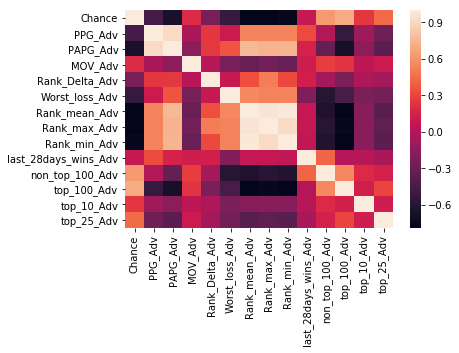

In [17]:
#Create arrays for features (X) and response (y)
X = ml_train_set.drop(['TeamID_main','TeamID_opponent','Season','Outcome'],axis=1) #series or dataframe/set of features in array

# Scale data before fitting to model
X_std = scaler.fit_transform(X)

# Heatmap shows high correlation between independent vars
sns.heatmap(X.corr()) 
plt.show()

## Principal Component Analysis (PCA)
* **Purpose:** Reduce the dimensionality of a data set consisting of many variables correlated with each other, either heavily or lightly, while retaining the variation present in the dataset, up to the maximum extent. The same is done by transforming the variables to a new set of variables, which are known as the principal components (or simply, the PCs)

In [18]:
#Adding PCA to deal with mutlicollinearity
from sklearn.decomposition import PCA

# Create PCA instance named model and fit the scaled data to it
model = PCA()
X_pca_features = model.fit_transform(X_std)

In [19]:
#Covariance matrix - Eigen Vals/Vecs
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,15)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,15)], 
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout=dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
py.plotly.iplot(fig, filename = 'PCA')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~dwalborn/0 or inside your plot.ly account where it is named 'PCA'


* The plot above shows that **46.83% of the variance** can be explained by the **first principal component** alone. 
* The **second principal component** bears **13.84%** of the information
* Together, the first **nine principal components** contain **96.46%** of the information.

## Logistic Regression
* **Purpose:** Our dependent variable is a win or loss (binary). Logistic regression will use our input variables to determine a probability of our binary outcome

In [20]:
# Scale data before fitting to model
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_pca_features,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
#Shape dataframe to predict on
submission_2019 = training_data.loc[training_data['Season']==2019]

ml_test_set  = submission_2019.fillna(0).drop(['TeamID_main','TeamID_opponent','Season','Outcome'],axis=1)
ml_test_set.head()

,Chance,PPG_Adv,PAPG_Adv,MOV_Adv,Rank_Delta_Adv,Worst_loss_Adv,Rank_mean_Adv,Rank_max_Adv,Rank_min_Adv,last_28days_wins_Adv,non_top_100_Adv,top_100_Adv,top_10_Adv,top_25_Adv
34864,0.464286,0.0,0.0,0.0,-10,0.0,-4.333333,-10,-2,0.0,0.0,0.0,0.0,0.0
34865,0.423077,0.0,0.0,0.0,19,0.0,27.888889,37,13,0.0,0.0,0.0,0.0,0.0
34866,0.100000,0.0,0.0,0.0,7,0.0,19.277778,23,12,0.0,0.0,0.0,0.0,0.0
34867,0.384615,0.0,0.0,0.0,35,0.0,26.444444,50,10,0.0,0.0,0.0,0.0,0.0
34868,0.142857,0.0,0.0,0.0,32,0.0,71.333333,87,48,0.0,0.0,0.0,0.0,0.0


In [22]:
# Scale and transform mltestset
ml_test_set_scaled = scaler.transform(ml_test_set)
ml_test_set_pca = model.transform(ml_test_set_scaled)

# Predict on data for 2019
y_predicted_prob = logreg.predict_proba(ml_test_set_pca)[:,1]
submission_2019['pred'] = y_predicted_prob
submission_2019 = submission_2019[['Season', 'TeamID_main', 'TeamID_opponent', 'pred']]

# Preview
submission_2019.head()

,Season,TeamID_main,TeamID_opponent,pred
34864,2019,1181,1277,0.447879
34865,2019,1261,1277,0.381504
34866,2019,1268,1277,0.134635
34867,2019,1257,1277,0.357677
34868,2019,1125,1277,0.130283


# Submission

## Create Submission File

* The final submission file includes a probability for every potential matchup in this year's tournament. The competition requires a specific format for the submission file which we create here

In [23]:
submission = submission_2019

#convert necessary columns to string for concatenation
submission['a'] = submission['Season'].astype(str) + '_'
submission['b'] = submission['TeamID_main'].astype(str) + '_'
submission['c'] = submission['TeamID_opponent'].astype(str)
submission['ID'] = submission['a'] + submission['b'] + submission['c']
submission = submission[['ID','pred']]

# Export to CSV for submission
submission.to_csv('Submission_CSV.csv', index = False)

# Preview Submission File
submission.head()

,ID,pred
34864,2019_1181_1277,0.447879
34865,2019_1261_1277,0.381504
34866,2019_1268_1277,0.134635
34867,2019_1257_1277,0.357677
34868,2019_1125_1277,0.130283


## Preview with Team Names

In [24]:
Readable_submission = pd.DataFrame()
Readable_submission['Team A'] =  submission_2019['TeamID_main']
Readable_submission['Team B'] =  submission_2019['TeamID_opponent']
Readable_submission['Prob Team A Wins'] = submission_2019['pred']
Readable_submission['Prob Team B Wins'] = 1- submission_2019['pred']

# Add team names
team_names = dim_teams.drop(columns={'FirstD1Season', 'LastD1Season'})
Readable_submission = pd.merge(Readable_submission
                               , team_names
                               , how = 'left'
                               , left_on=['Team A']
                               , right_on=['TeamID']).drop(columns={'Team A', 'TeamID'}).rename(columns={'TeamName' : 'Team A'})
Readable_submission = pd.merge(Readable_submission
                               , team_names
                               , how = 'left'
                               , left_on=['Team B']
                               , right_on=['TeamID']).drop(columns={'Team B', 'TeamID'}).rename(columns={'TeamName' : 'Team B'})
Readable_submission = Readable_submission[['Team A', 'Prob Team A Wins', 'Team B', 'Prob Team B Wins']].sort_values('Team A')

# Preview Output
Readable_submission

,Team A,Prob Team A Wins,Team B,Prob Team B Wins
2277,Abilene Chr,0.389754,Arizona St,0.610246
1105,Abilene Chr,0.641052,Prairie View,0.358948
1854,Abilene Chr,0.326674,Wisconsin,0.673326
777,Abilene Chr,0.337766,Nevada,0.662234
1281,Abilene Chr,0.321736,Wofford,0.678264
169,Abilene Chr,0.336102,Maryland,0.663898
1917,Abilene Chr,0.349232,Villanova,0.650768
647,Abilene Chr,0.063636,Michigan,0.936364
1956,Abilene Chr,0.351711,Mississippi,0.648289
1052,Abilene Chr,0.493107,Montana,0.506893
